# Class Diagrams

This is a simple viewer for class diagrams.  Customized towards the book.

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Debugger.ipynb).

In [1]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.ClassDiagram import <identifier>
```

and then make use of the following features.


The function `display_class_hierarchy()` function shows the class hierarchy for the given class (or list of classes). 
* The keyword parameter `public_methods`, if given, is a list of "public" methods to be used by clients (default: all methods with docstrings).
* The keyword parameter `abstract_classes`, if given, is a list of classes to be displayed as "abstract" (i.e. with a cursive class name).

```python
>>> display_class_hierarchy(D_Class, abstract_classes=[A_Class])
```

![](PICS/ClassDiagram-synopsis-1.svg)



## Getting a Class Hierarchy

In [2]:
import inspect

Using `mro()`, we can access the class hierarchy.  We make sure to avoid duplicates created by `class X(X)`.

In [3]:
from typing import Callable, Dict, Type, Set, List, Union, Any, Tuple, Optional

In [4]:
def class_hierarchy(cls: Type) -> List[Type]:
    superclasses = cls.mro()
    hierarchy = []
    last_superclass_name = ""

    for superclass in superclasses:
        if superclass.__name__ != last_superclass_name:
            hierarchy.append(superclass)
            last_superclass_name = superclass.__name__

    return hierarchy

Here's an example:

In [5]:
class A_Class:
    """A Class which does A thing right.
    Comes with a longer docstring."""

    def foo(self) -> None:
        """The Adventures of the glorious Foo"""
        pass

    def quux(self) -> None:
        """A method that is not used."""
        pass

In [6]:
class A_Class(A_Class):
    # We define another function in a separate cell.

    def second(self) -> None:
        pass

In [7]:
class B_Class(A_Class):
    """A subclass inheriting some methods."""

    VAR = "A variable"

    def foo(self) -> None:
        """A WW2 foo fighter."""
        pass

    def bar(self, qux: Any = None, bartender: int = 42) -> None:
        """A qux walks into a bar.
        `bartender` is an optional attribute."""
        pass

In [8]:
class C_Class:
    """A class injecting some method"""

    def qux(self) -> None:
        pass

In [9]:
class D_Class(B_Class, C_Class):
    """A subclass inheriting from multiple superclasses.
    Comes with a fairly long, but meaningless documentation."""

    def foo(self) -> None:
        B_Class.foo(self)

In [10]:
class D_Class(D_Class):
    pass  # An incremental addiiton that should not impact D's semantics

In [11]:
class_hierarchy(D_Class)

[__main__.D_Class,
 __main__.B_Class,
 __main__.A_Class,
 __main__.C_Class,
 object]

## Getting a Class Tree

We can use `__bases__` to obtain the immediate base classes.

In [12]:
D_Class.__bases__

(__main__.D_Class,)

`class_tree()` returns a class tree, using the "lowest" (most specialized) class with the same name.

In [13]:
def class_tree(cls: Type, lowest: Type = None) -> List[Tuple[Type, List]]:
    ret = []
    for base in cls.__bases__:
        if base.__name__ == cls.__name__:
            if not lowest:
                lowest = cls
            ret += class_tree(base, lowest)
        else:
            if lowest:
                cls = lowest
            ret.append((cls, class_tree(base)))

    return ret

In [14]:
class_tree(D_Class)

[(__main__.D_Class, [(__main__.B_Class, [(__main__.A_Class, [])])]),
 (__main__.D_Class, [(__main__.C_Class, [])])]

In [15]:
class_tree(D_Class)[0][0]

__main__.D_Class

In [16]:
assert class_tree(D_Class)[0][0] == D_Class

`class_set()` flattens the tree into a set:

In [17]:
def class_set(classes: Union[Type, List[Type]]) -> Set[Type]:
    if not isinstance(classes, list):
        classes = [classes]

    ret = set()

    def traverse_tree(tree: List[Tuple[Type, List]]) -> None:
        for (cls, subtrees) in tree:
            ret.add(cls)
            for subtree in subtrees:
                traverse_tree(subtrees)

    for cls in classes:
        traverse_tree(class_tree(cls))

    return ret

In [18]:
class_set(D_Class)

{__main__.A_Class, __main__.B_Class, __main__.C_Class, __main__.D_Class}

In [19]:
assert A_Class in class_set(D_Class)

In [20]:
assert B_Class in class_set(D_Class)

In [21]:
assert C_Class in class_set(D_Class)

In [22]:
assert D_Class in class_set(D_Class)

In [23]:
class_set([B_Class, C_Class])

{__main__.A_Class, __main__.B_Class, __main__.C_Class}

### Getting Docs

In [24]:
A_Class.__doc__

In [25]:
A_Class.__bases__[0].__doc__

'A Class which does A thing right.\n    Comes with a longer docstring.'

In [26]:
A_Class.__bases__[0].__name__

'A_Class'

In [27]:
D_Class.foo

<function __main__.D_Class.foo(self) -> None>

In [28]:
D_Class.foo.__doc__

In [29]:
A_Class.foo.__doc__

'The Adventures of the glorious Foo'

In [30]:
def docstring(obj: Any) -> str:
    doc = inspect.getdoc(obj)
    return doc if doc else ""

In [31]:
docstring(A_Class)

'A Class which does A thing right.\nComes with a longer docstring.'

In [32]:
docstring(D_Class.foo)

'A WW2 foo fighter.'

In [33]:
def unknown() -> None:
    pass

In [34]:
docstring(unknown)

''

In [35]:
import html

In [36]:
import re

In [37]:
def escape(text: str) -> str:
    text = html.escape(text)
    assert '<' not in text
    assert '>' not in text
    text = text.replace('{', '&#x7b;')
    text = text.replace('|', '&#x7c;')
    text = text.replace('}', '&#x7d;')
    return text

In [38]:
escape("f(foo={})")

'f(foo=&#x7b;&#x7d;)'

In [39]:
def escape_doc(docstring: str) -> str:
    DOC_INDENT = 0
    docstring = "&#x0a;".join(
        ' ' * DOC_INDENT + escape(line).strip()
        for line in docstring.split('\n')
    )
    return docstring

In [40]:
print(escape_doc("'Hello\n    {You|Me}'"))

&#x27;Hello&#x0a;&#x7b;You&#x7c;Me&#x7d;&#x27;


## Getting Methods and Variables

In [41]:
inspect.getmembers(D_Class)

[('VAR', 'A variable'),
 ('__class__', type),
 ('__delattr__', <slot wrapper '__delattr__' of 'object' objects>),
 ('__dict__', mappingproxy({'__module__': '__main__', '__doc__': None})),
 ('__dir__', <method '__dir__' of 'object' objects>),
 ('__doc__', None),
 ('__eq__', <slot wrapper '__eq__' of 'object' objects>),
 ('__format__', <method '__format__' of 'object' objects>),
 ('__ge__', <slot wrapper '__ge__' of 'object' objects>),
 ('__getattribute__', <slot wrapper '__getattribute__' of 'object' objects>),
 ('__gt__', <slot wrapper '__gt__' of 'object' objects>),
 ('__hash__', <slot wrapper '__hash__' of 'object' objects>),
 ('__init__', <slot wrapper '__init__' of 'object' objects>),
 ('__init_subclass__', <function D_Class.__init_subclass__>),
 ('__le__', <slot wrapper '__le__' of 'object' objects>),
 ('__lt__', <slot wrapper '__lt__' of 'object' objects>),
 ('__module__', '__main__'),
 ('__ne__', <slot wrapper '__ne__' of 'object' objects>),
 ('__new__', <function object.__new__

In [42]:
def class_items(cls: Type, pred: Callable) -> List[Tuple[str, Any]]:
    def _class_items(cls: Type) -> List:
        all_items = inspect.getmembers(cls, pred)
        for base in cls.__bases__:
            all_items += _class_items(base)

        return all_items

    unique_items = []
    items_seen = set()
    for (name, item) in _class_items(cls):
        if name not in items_seen:
            unique_items.append((name, item))
            items_seen.add(name)

    return unique_items

In [43]:
def class_methods(cls: Type) -> List[Tuple[str, Callable]]:
    return class_items(cls, inspect.isfunction)

In [44]:
def defined_in(name: str, cls: Type) -> bool:
    if not hasattr(cls, name):
        return False

    defining_classes = []

    def search_superclasses(name: str, cls: Type) -> None:
        if not hasattr(cls, name):
            return

        for base in cls.__bases__:
            if hasattr(base, name):
                defining_classes.append(base)
                search_superclasses(name, base)

    search_superclasses(name, cls)

    if any(cls.__name__ != c.__name__ for c in defining_classes):
        return False  # Already defined in superclass

    return True

In [45]:
assert not defined_in('VAR', A_Class)

In [46]:
assert defined_in('VAR', B_Class)

In [47]:
assert not defined_in('VAR', C_Class)

In [48]:
assert not defined_in('VAR', D_Class)

In [49]:
def class_vars(cls: Type) -> List[Any]:
    def is_var(item: Any) -> bool:
        return not callable(item)

    return [item for item in class_items(cls, is_var) 
            if not item[0].startswith('__') and defined_in(item[0], cls)]

In [50]:
class_methods(D_Class)

[('bar',
  <function __main__.B_Class.bar(self, qux:Any=None, bartender:int=42) -> None>),
 ('foo', <function __main__.D_Class.foo(self) -> None>),
 ('quux', <function __main__.A_Class.quux(self) -> None>),
 ('qux', <function __main__.C_Class.qux(self) -> None>),
 ('second', <function __main__.A_Class.second(self) -> None>)]

In [51]:
class_vars(B_Class)

[('VAR', 'A variable')]

We're only interested in 

* functions _defined_ in that class
* functions that come with a docstring

In [52]:
def public_class_methods(cls: Type) -> List[Tuple[str, Callable]]:
    return [(name, method) for (name, method) in class_methods(cls) 
            if method.__qualname__.startswith(cls.__name__)]

In [53]:
def doc_class_methods(cls: Type) -> List[Tuple[str, Callable]]:
    return [(name, method) for (name, method) in public_class_methods(cls) 
            if docstring(method) is not None]

In [54]:
public_class_methods(D_Class)

[('foo', <function __main__.D_Class.foo(self) -> None>)]

In [55]:
doc_class_methods(D_Class)

[('foo', <function __main__.D_Class.foo(self) -> None>)]

In [56]:
def overloaded_class_methods(classes: Union[Type, List[Type]]) -> Set[str]:
    all_methods: Dict[str, Set[Callable]] = {}
    for cls in class_set(classes):
        for (name, method) in class_methods(cls):
            if method.__qualname__.startswith(cls.__name__):
                all_methods.setdefault(name, set())
                all_methods[name].add(cls)

    return set(name for name in all_methods if len(all_methods[name]) >= 2)

In [57]:
overloaded_class_methods(D_Class)

{'foo'}

## Drawing Class Hierarchy with Method Names

In [58]:
from inspect import signature

In [59]:
import warnings

In [60]:
def display_class_hierarchy(classes: Union[Type, List[Type]], 
                            public_methods: Optional[List] = None,
                            abstract_classes: Optional[List] = None,
                            include_methods: bool = True,
                            include_class_vars: bool =True,
                            include_legend: bool = True,
                            project: str = 'fuzzingbook',
                            log: bool = False) -> Any:
    """Visualize a class hierarchy.
`classes` is a Python class (or a list of classes) to be visualized.
`public_methods`, if given, is a list of methods to be shown as "public" (bold).
  (Default: all methods with a docstring)
`abstract_classes`, if given, is a list of classes to be shown as "abstract" (cursive).
  (Default: all classes with an abstract method)
`include_methods`: if True, include all methods (default)
`include_legend`: if True, include a legend (default)
    """
    from graphviz import Digraph

    if project == 'debuggingbook':
        CLASS_FONT = 'Raleway, Helvetica, Arial, sans-serif'
        CLASS_COLOR = '#6A0DAD'  # HTML 'purple'
    else:
        CLASS_FONT = 'Patua One, Helvetica, sans-serif'
        CLASS_COLOR = '#B03A2E'

    METHOD_FONT = "'Fira Mono', 'Source Code Pro', 'Courier', monospace"
    METHOD_COLOR = 'black'

    if isinstance(classes, list):
        starting_class = classes[0]
    else:
        starting_class = classes
        classes = [starting_class]

    title = starting_class.__name__ + " class hierarchy"

    dot = Digraph(comment=title)
    dot.attr('node', shape='record', fontname=CLASS_FONT)
    dot.attr('graph', rankdir='BT', tooltip=title)
    dot.attr('edge', arrowhead='empty')
    edges = set()
    overloaded_methods: Set[str] = set()

    drawn_classes = set()

    def method_string(method_name: str, public: bool, overloaded: bool,
                      fontsize: float = 10.0) -> str:
        method_string = f'<font face="{METHOD_FONT}" point-size="{str(fontsize)}">'

        if overloaded:
            name = f'<i>{method_name}()</i>'
        else:
            name = f'{method_name}()'

        if public:
            method_string += f'<b>{name}</b>'
        else:
            method_string += f'<font color="{METHOD_COLOR}">' \
                             f'{name}</font>'

        method_string += '</font>'
        return method_string

    def var_string(var_name: str, fontsize: int = 10) -> str:
        var_string = f'<font face="{METHOD_FONT}" point-size="{str(fontsize)}">'
        var_string += f'{var_name}'
        var_string += '</font>'
        return var_string

    def is_overloaded(method_name: str, f: Any) -> bool:
        return (method_name in overloaded_methods or
                (docstring(f) is not None and "in subclasses" in docstring(f)))

    def is_abstract(cls: Type) -> bool:
        if not abstract_classes:
            return inspect.isabstract(cls)

        return (cls in abstract_classes or
                any(c.__name__ == cls.__name__ for c in abstract_classes))

    def is_public(method_name: str, f: Any) -> bool:
        if public_methods:
            return (method_name in public_methods or
                    f in public_methods or
                    any(f.__qualname__ == m.__qualname__
                        for m in public_methods))

        return bool(docstring(f))

    def class_vars_string(cls: Type, url: str) -> str:
        cls_vars = class_vars(cls)
        if len(cls_vars) == 0:
            return ""

        vars_string = f'<table border="0" cellpadding="0" ' \
                      f'cellspacing="0" ' \
                      f'align="left" tooltip="{cls.__name__}" href="#">'

        for (name, var) in cls_vars:
            if log:
                print(f"    Drawing {name}")

            var_doc = escape(f"{name} = {repr(var)}")
            tooltip = f' tooltip="{var_doc}"'
            href = f' href="{url}"'
            vars_string += f'<tr><td align="left" border="0"' \
                           f'{tooltip}{href}>'

            vars_string += var_string(name)
            vars_string += '</td></tr>'

        vars_string += '</table>'
        return vars_string

    def class_methods_string(cls: Type, url: str) -> str:
        methods = public_class_methods(cls)
        # return "<br/>".join([name + "()" for (name, f) in methods])
        if len(methods) == 0:
            return ""

        methods_string = f'<table border="0" cellpadding="0" ' \
                         f'cellspacing="0" ' \
                         f'align="left" tooltip="{cls.__name__}" href="#">'

        for public in [True, False]:
            for (name, f) in methods:
                if public != is_public(name, f):
                    continue

                if log:
                    print(f"    Drawing {name}()")

                if is_public(name, f) and not docstring(f):
                    warnings.warn(f"{f.__qualname__}() is listed as public,"
                                  f" but has no docstring")

                overloaded = is_overloaded(name, f)

                method_doc = escape(name + str(inspect.signature(f)))
                if docstring(f):
                    method_doc += ":&#x0a;" + escape_doc(docstring(f))

                # Tooltips are only shown if a href is present, too
                tooltip = f' tooltip="{method_doc}"'
                href = f' href="{url}"'
                methods_string += f'<tr><td align="left" border="0"' \
                                  f'{tooltip}{href}>'

                methods_string += method_string(name, public, overloaded)

                methods_string += '</td></tr>'

        methods_string += '</table>'
        return methods_string

    def display_class_node(cls: Type) -> None:
        name = cls.__name__

        if name in drawn_classes:
            return
        drawn_classes.add(name)

        if log:
            print(f"Drawing class {name}")

        if cls.__module__ == '__main__':
            url = '#'
        else:
            url = cls.__module__ + '.ipynb'

        if is_abstract(cls):
            formatted_class_name = f'<i>{cls.__name__}</i>'
        else:
            formatted_class_name = cls.__name__

        if include_methods or include_class_vars:
            vars = class_vars_string(cls, url)
            methods = class_methods_string(cls, url)
            spec = '<{<b><font color="' + CLASS_COLOR + '">' + \
                formatted_class_name + '</font></b>'
            if include_class_vars and vars:
                spec += '|' + vars
            if include_methods and methods:
                spec += '|' + methods
            spec += '}>'
        else:
            spec = '<' + formatted_class_name + '>'

        class_doc = escape('class ' + cls.__name__)
        if docstring(cls):
            class_doc += ':&#x0a;' + escape_doc(docstring(cls))
        else:
            warnings.warn(f"Class {cls.__name__} has no docstring")

        dot.node(name, spec, tooltip=class_doc, href=url)

    def display_class_trees(trees: List[Tuple[Type, List]]) -> None:
        for tree in trees:
            (cls, subtrees) = tree
            display_class_node(cls)

            for subtree in subtrees:
                (subcls, _) = subtree

                if (cls.__name__, subcls.__name__) not in edges:
                    dot.edge(cls.__name__, subcls.__name__)
                    edges.add((cls.__name__, subcls.__name__))

            display_class_trees(subtrees)

    def display_legend() -> None:
        fontsize = 8.0

        label = f'<b><font color="{CLASS_COLOR}">Legend</font></b><br align="left"/>' 

        for item in [
            method_string("public_method",
                          public=True, overloaded=False, fontsize=fontsize),
            method_string("private_method",
                          public=False, overloaded=False, fontsize=fontsize),
            method_string("overloaded_method",
                          public=False, overloaded=True, fontsize=fontsize)
        ]:
            label += '&bull;&nbsp;' + item + '<br align="left"/>'

        label += f'<font face="Helvetica" point-size="{str(fontsize + 1)}">' \
                 'Hover over names to see doc' \
                 '</font><br align="left"/>'

        dot.node('Legend', label=f'<{label}>', shape='plain', fontsize=str(fontsize + 2))

    for cls in classes:
        tree = class_tree(cls)
        overloaded_methods = overloaded_class_methods(cls)
        display_class_trees(tree)

    if include_legend:
        display_legend()

    return dot

Drawing class D_Class
    Drawing foo()
Drawing class B_Class
    Drawing VAR
    Drawing bar()
    Drawing foo()
Drawing class A_Class
    Drawing foo()
    Drawing quux()
    Drawing second()
Drawing class C_Class
    Drawing qux()


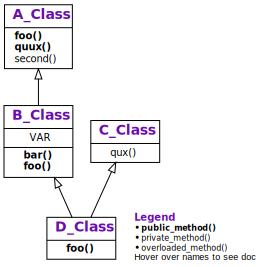

In [61]:
display_class_hierarchy(D_Class, project='debuggingbook', log=True)

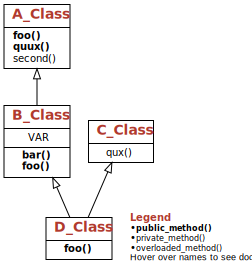

In [62]:
display_class_hierarchy(D_Class, project='fuzzingbook')

Here is a variant with abstract classes and logging:

Drawing class A_Class
    Drawing quux()
    Drawing foo()
    Drawing second()
Drawing class B_Class
    Drawing VAR
    Drawing bar()
    Drawing foo()


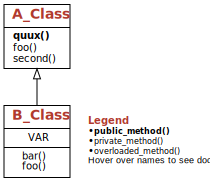

In [63]:
display_class_hierarchy([A_Class, B_Class],
                        abstract_classes=[A_Class],
                        public_methods=[
                            A_Class.quux,
                        ], log=True)

## Synopsis

The function `display_class_hierarchy()` function shows the class hierarchy for the given class (or list of classes). 
* The keyword parameter `public_methods`, if given, is a list of "public" methods to be used by clients (default: all methods with docstrings).
* The keyword parameter `abstract_classes`, if given, is a list of classes to be displayed as "abstract" (i.e. with a cursive class name).

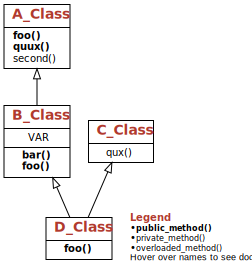

In [64]:
display_class_hierarchy(D_Class, abstract_classes=[A_Class])

## Exercises

Enjoy!